In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import librosa
import time
from pathlib import Path
import pickle
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
import pandas as pd

import sys
import os

from net import EffNetb0
import math
from data_utils.custom_valid_audio_dataset import AudioDataset

In [18]:
model_path = 'models/test_run5/effnet_2'
valid_dataset_path = '../../HumTrans/CQT_VALID'

device = torch.device('cuda')

validation_dataset = AudioDataset(valid_dataset_path, 11)
valid_loader = DataLoader(
    validation_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
)

FRAME_LENGTH = librosa.frames_to_time(1, sr=44100, hop_length=1024)

model = EffNetb0().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
print('Model read from {}.'.format(model_path))

true_onset_pred = []
false_onset_pred = []

true_offset_pred = []
false_offset_pred = []

model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(valid_loader)):

        input_tensor = batch[0].to(device)

        onset_prob = batch[1][:, 0].float().to(device)
        offset_prob = batch[1][:, 1].float().to(device)
        pitch_octave = batch[1][:, 2].long().to(device)
        pitch_class = batch[1][:, 3].long().to(device)

        onset_logits, offset_logits, pitch_octave_logits, pitch_class_logits = model(input_tensor)
        onset_probs, offset_probs = torch.sigmoid(onset_logits).detach().cpu().numpy(), torch.sigmoid(offset_logits).detach().cpu().numpy()
        
        # for ii, flag in enumerate(batch[2]):#enumerate(onset_prob):
        for ii, flag in enumerate(onset_prob):
            if flag > 0.5:
                true_onset_pred.append(onset_probs[ii])
            else:
                false_onset_pred.append(onset_probs[ii])
                
        # for ii, flag in enumerate(batch[2]):#enumerate(offset_prob):
        # for ii, flag in enumerate(offset_prob):
        #     if flag > 0.5:
        #         true_offset_pred.append(offset_probs[ii])
        #     else:
        #         false_offset_pred.append(offset_probs[ii])

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Model read from models/test_run5/effnet_2.


  0%|          | 0/3644 [00:00<?, ?it/s]

In [3]:
input_tensor.size()

torch.Size([32, 1, 21, 168])

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

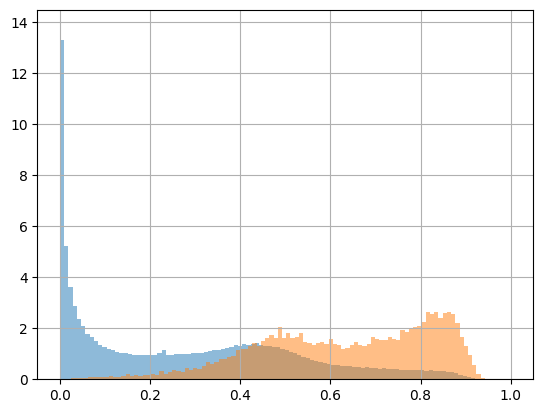

In [13]:
plt.hist(false_onset_pred, bins=100, density=True, alpha=0.5)
plt.hist(true_onset_pred, bins=100, density=True, alpha=0.5)
plt.ylim(0, 14.5)
plt.xlim(-0.05, 1.05)
plt.grid()
plt.show()

In [16]:
x = np.array(false_onset_pred)
# x = np.array(true_onset_pred)

np.sum((x > 0.5)) / np.prod(x.shape)

0.2033369122330987

In [17]:
x = np.array(true_onset_pred)

np.sum((x > 0.5)) / np.prod(x.shape)

0.7276899782341251

In [14]:
model

EffNetb0(
  (effnet): GenEfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [12]:
import numpy as np

np.power(0, 1)

0